# Wall project

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import libMobility as lm
import logging
import os
from tqdm import tqdm
logging.basicConfig(level=logging.DEBUG)
precision = np.float32 if lm.SelfMobility.precision == "float" else np.float64


def create_square_patch(side, density):
    # Density is the number of particles per unit area in the square patch
    n = int(side * side * density)
    nx = int(np.sqrt(n))
    ny = nx
    n = nx * ny
    sep = side / nx
    pos = np.zeros((n, 3))
    pos = np.array(
        [
            [i * sep - side * 0.5, j * sep - side * 0.5, 0]
            for i in range(nx)
            for j in range(ny)
        ]
    )
    return pos


def create_tracer_box(lxy, lz, density):
    """Create a box centered at 0,0 in XY and such that min(z) = 0"""
    # Density is the number of particles per unit volume in the rectangular box
    nxy = int(np.sqrt(np.cbrt(density) ** 2 * lxy * lxy))
    nz = int(np.cbrt(density) * lz)
    x = np.arange(-lxy * 0.5, lxy * 0.5, lxy / nxy)
    y = x.copy()
    z = np.arange(0, lz, lz / nz)
    xx, yy, zz = np.meshgrid(x, y, z, indexing="ij")
    pos = np.column_stack((xx.ravel(), yy.ravel(), zz.ravel()))
    return pos


def init_solver(numberParticles):
    nb = lm.NBody(periodicityX="open", periodicityY="open", periodicityZ="open")
    nb.setParameters(algorithm="advise", Nbatch=1, NperBatch=numberParticles)
    nb.initialize(
        temperature=0.0,
        viscosity=1 / (6 * np.pi),
        hydrodynamicRadius=1.0,
        numberParticles=numberParticles,
        needsTorque=False,
    )
    return nb


class FixedPointSprings:
    def __init__(self, kspring, indexes, equilibrium_pos):
        self.kspring = kspring
        self.indexes = indexes.copy()
        self.equilibrium_pos = equilibrium_pos.copy()

    def compute(self, all_pos):
        delta = all_pos[self.indexes] - self.equilibrium_pos
        return -self.kspring * delta.copy()


# Main program

# Parameters
quadrupole_width = 10           # Width of the quadrupole
quadrupole_density = 1          # Density of the quadrupole
tracer_width = quadrupole_width # Width of the tracer box
tracer_density = 1              # Density of the tracer box
kspring = 10                    # Spring constant
dt = 0.001                      # Time step
pull_magnitude = 10             # Pull force magnitude

# System configuration
wall_pos = create_square_patch(quadrupole_width, quadrupole_density)                # Create a square patch
tracers = create_tracer_box(tracer_width, 2, tracer_density) + np.array([0, 0, 1]) # Create a box of tracers
f_tracers = np.zeros_like(tracers, dtype=precision)                                 # Initialize forces on tracers
pull_particle = np.array([0, 0, -1], dtype=precision)                               # Pull particle position
pull_force = np.array([0, 0, pull_magnitude], dtype=precision)                      # Pull force
all_pos = np.vstack((wall_pos, tracers, pull_particle))                             # Combine all positions
springs = FixedPointSprings(kspring = kspring,                                      # Create springs for wall particles
                            indexes = np.arange(wall_pos.shape[0]),
                            equilibrium_pos = wall_pos)                                               

# Initialization
all_forces = np.vstack((np.zeros_like(wall_pos),
                        np.zeros_like(tracers,dtype=precision),
                        pull_force))                                # Initialize forces on all particles

logging.info(f"Total particles: {all_pos.shape[0]}")                # Log total number of particles                              
solver = init_solver(all_pos.shape[0])                              # Initialize solver


# Simulation & Tracking loop
os.makedirs("traj", exist_ok=True)                          # Create directory for trajectory files
for i in tqdm(range(100)):                                  # Loop over time steps
    solver.setPositions(all_pos)                            # Set positions in solver
    all_forces = np.zeros_like(all_pos)                     # Reset forces
    all_forces[springs.indexes] = springs.compute(all_pos)  # Compute spring forces
    all_forces[-1] = pull_force                             # Set pull force
    result, _ = solver.Mdot(forces=all_forces)              # Compute velocities using libMobility solver
    result[-1] = 0                                          # Set velocity of pull particle to 0
    all_pos = all_pos + result * dt                         # Update positions
    v = result[:, 2]                                        # Extract z-component of velocity
    # Print, for each line: X Y Z 0.25, v
    np.savetxt(
        f"traj/pos_{i:06d}.txt",
        np.column_stack((all_pos, 0.25 * np.ones(all_pos.shape[0]), v)),
        fmt="%f",
    )

INFO:root:Total particles: 301
100%|██████████| 100/100 [00:00<00:00, 550.95it/s]


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7ff7760326c0>


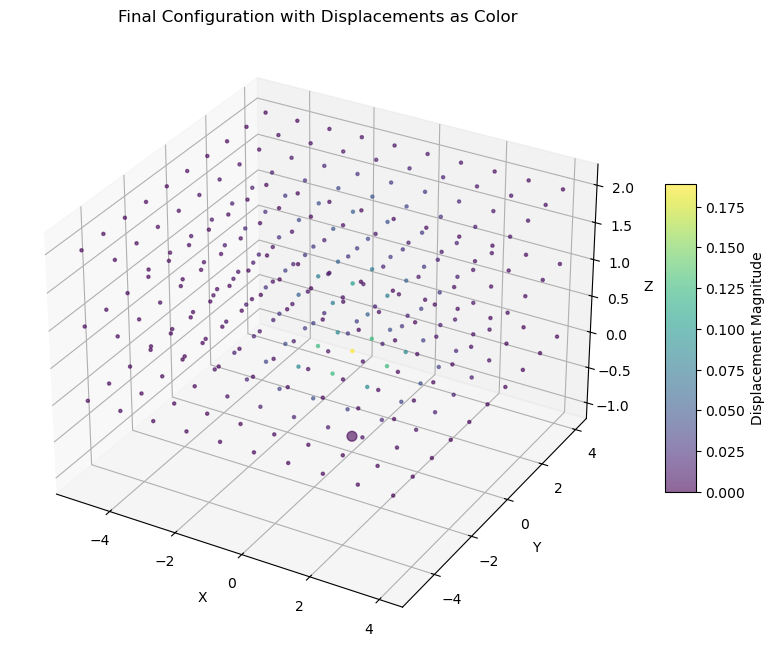

In [16]:
# Calculate displacements (magnitude of the difference between initial and final positions)
displacements = np.linalg.norm(all_pos - np.vstack((wall_pos, tracers, pull_particle)), axis=1)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot particles with displacements as color
scatter = ax.scatter(all_pos[:, 0], all_pos[:, 1], all_pos[:, 2], c=displacements, cmap='viridis',
                     s=np.concatenate(([5 / quadrupole_density] * len(wall_pos), [5 / tracer_density] * len(tracers), [50])),
                     alpha=0.6)

# Add color bar to indicate displacement magnitude
cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Displacement Magnitude')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Final Configuration with Displacements as Color')
plt.show()
